This notebook is an adaptation from Lisa Alazraki's notebook used for training the previous version of the chatbot (https://www.doc.ic.ac.uk/~ae/papers/Lisa_Alazraki_report.pdf).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import gc

from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
train_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_train.txt"
test_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_test.txt"
val_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_val.txt"

In [ ]:
label2int = {
  "sadness": 1,
  "joy": 2,
  "anger": 3,
  "fear": 4,
  "love": 5,
  "instability": 6,
  "disgust": 7,
  "disappointment": 8,
  "shame": 9,
  "guilt": 10,
  "envy": 11,
  "jealous": 12
}

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
#Load the tokenizer for the T5-base model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
#check how it encodes the labels (they're all single ids)
emotions = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy", "jealous"]
for em in emotions:
  print(tokenizer.encode(em))

[24784]
[3922]
[11213]
[2971]
[333]
[29440]
[27635]
[19142]
[12447]
[20595]
[30312]
[23022]


In [ ]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  #might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  #might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       #tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       #tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
def get_dataset(tokenizer, type_path, params):
  return EmotionDataset(tokenizer=tokenizer, data_dir=params['data_dir'], type_path=type_path,  max_len=params['max_seq_length'])

In [ ]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, params):
    super(T5FineTuner, self).__init__()
    self.params = params
    
    self.model = T5ForConditionalGeneration.from_pretrained(params['model_name_or_path'])
    self.tokenizer = T5Tokenizer.from_pretrained(params['tokenizer_name_or_path'])
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    #self.log(f"ptl/train_loss", loss)
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    #self.log(f"ptl/train_loss", loss)
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.params['weight_decay'],
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.params['learning_rate'], eps=self.params['adam_epsilon'])
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="bt_train", params=self.params)
    dataloader = DataLoader(train_dataset, batch_size=self.params['train_batch_size'], drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.params['train_batch_size'] * max(1, self.params['n_gpu'])))
        // self.params['gradient_accumulation_steps']
        * float(self.params['num_train_epochs'])
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.params['warmup_steps'], num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="bt_val", params=self.params)
    return DataLoader(val_dataset, batch_size=self.params['eval_batch_size'], num_workers=4)

In [ ]:
#load tokenizer for our model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [ ]:
dataset = EmotionDataset(tokenizer, '/content/drive/MyDrive/Individual Project/Data/Emotion', 'bt_val', 512)

In [ ]:
#show one sample
data = dataset[57]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i have a car and a job but she chose him he doesnt have a job and still stays with his parents
jealous


In [ ]:
train_config = dict(
    data_dir='/content/drive/MyDrive/Individual Project/Data/Emotion/', # path for data files
    output_dir='/content/', # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-3,
    weight_decay=0.0,
    adam_epsilon=1e-3,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=6,
    gradient_accumulation_steps=2,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False,
    opt_level='O1',
    max_grad_norm=1.0, 
    seed=21,
)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=train_config['output_dir'], prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=train_config['gradient_accumulation_steps'],
    gpus=train_config['n_gpu'],
    max_epochs=train_config['num_train_epochs'],
    early_stop_callback=False,
    precision= 16 if train_config['fp_16'] else 32,
    amp_level=train_config['opt_level'],
    gradient_clip_val=train_config['max_grad_norm'],
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

def train_model(config, num_gpus=1):
    model = T5FineTuner(config)
    metrics = {"loss": "ptl/val_loss"}
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        filepath=config['output_dir'], prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
    )
    trainer = pl.Trainer(**train_params)
    trainer.fit(model)

    return model

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /content/ exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#training loop
model = T5FineTuner(train_config)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.6623, device='cuda:0')

INFO:__main__:loss = tensor(0.9323, device='cuda:0')

INFO:__main__:train_loss = tensor(0.9323, device='cuda:0')

INFO:__main__:val_loss = tensor(0.6623, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(3.1828, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4972, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.5060, device='cuda:0')

INFO:__main__:train_loss = tensor(0.5060, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4972, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.6700, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4280, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(0.4428, device='cuda:0')

INFO:__main__:train_loss = tensor(0.4428, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4280, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5151, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4241, device='cuda:0')

INFO:__main__:epoch = 2

INFO:__main__:loss = tensor(0.3328, device='cuda:0')

INFO:__main__:train_loss = tensor(0.3328, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4241, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.4449, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4176, device='cuda:0')

INFO:__main__:epoch = 3

INFO:__main__:loss = tensor(0.0598, device='cuda:0')

INFO:__main__:train_loss = tensor(0.0598, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4176, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.3685, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.4235, device='cuda:0')

INFO:__main__:epoch = 4

INFO:__main__:loss = tensor(0.1424, device='cuda:0')

INFO:__main__:train_loss = tensor(0.1424, device='cuda:0')

INFO:__main__:val_loss = tensor(0.4235, device='cuda:0')



1

In [ ]:
torch.save(model.state_dict(), '/content/T5_finetuned_bt.pt')

In [ ]:
import textwrap
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
dataset = EmotionDataset(tokenizer, '/content/drive/MyDrive/Individual Project/Data/Emotion', 'bt_test', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
#print some predictions to view
for i in range(5):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: i get really nervous when i see my girlfriend chatting with other men

Actual sentiment: jealous
predicted sentiment: jealous

text: i feel really happy with my family

Actual sentiment: love
predicted sentiment: love

text: i feel guilty that i kept the excess change i received at the cafe

Actual sentiment: guilt
predicted sentiment: guilt

text: amazing thank you for asking

Actual sentiment: joy
predicted sentiment: love

text: im feeling wonderful thank you

Actual sentiment: joy
predicted sentiment: joy



In [ ]:
#predict whole test set
dataset = EmotionDataset(tokenizer, '/content/drive/MyDrive/Individual Project/Data/Emotion', 'bt_test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')
    #deal with invalid predictions if they arise:
    del outputs[i]
    del targets[i]

In [ ]:
#metrics
print(classification_report(targets, outputs, digits=4))

                precision    recall  f1-score   support

         anger     0.8077    0.7778    0.7925        27
disappointment     0.8000    0.8000    0.8000        20
       disgust     0.8000    0.8000    0.8000        25
          envy     0.8571    0.8571    0.8571        28
          fear     0.8462    0.7857    0.8148        28
         guilt     0.7778    0.9545    0.8571        22
   instability     0.6190    0.6500    0.6341        20
       jealous     0.8276    0.8571    0.8421        28
           joy     0.8438    0.8438    0.8438        32
          love     0.9032    0.8750    0.8889        32
       sadness     0.6579    0.6579    0.6579        38
         shame     0.9231    0.7500    0.8276        16

      accuracy                         0.8006       316
     macro avg     0.8053    0.8007    0.8013       316
  weighted avg     0.8033    0.8006    0.8007       316



In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(targets, outputs)

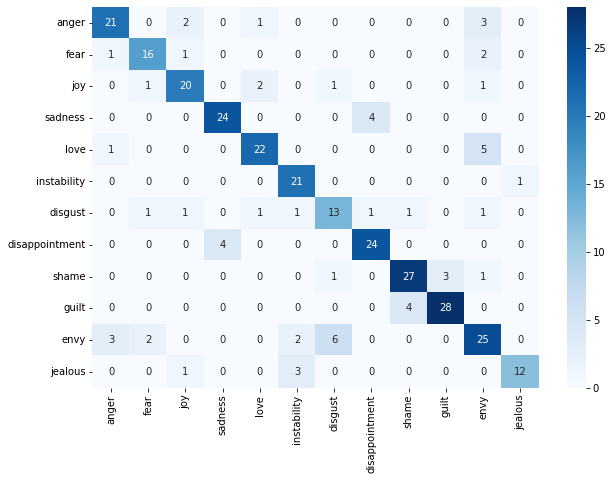

In [ ]:
cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "sadness", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy", "jealous"], columns = ["anger", "fear", "joy", "sadness", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy", "jealous"])
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
#define get_emotion function to generate individual prediction

import re

def get_emotion(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt').cuda()

  output = model.model.generate(input_ids=input_ids,
               max_length=2).cuda()

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

In [ ]:
text="I wish I had my sister's car" #change as necessary
get_emotion(text)

'envy'